In [1]:
import catboost

In [2]:
catboost

<module 'catboost' from '/home/noomkcalb/anaconda3/lib/python3.7/site-packages/catboost/__init__.py'>

In [3]:
from lifelines.datasets import load_rossi

In [4]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

In [5]:
rossi_df = load_rossi()

In [6]:
# cph = CoxPHFitter()
# cph.fit(rossi, duration_col='week', event_col='arrest')

In [7]:
# cph.predict_survival_function(rossi)

In [8]:
# cph.predict_survival_function(rossi)[range(10)].plot()

1. Вычислить риск для каждого из пользователей
2. Вычислить знаменатель кумулятивной суммой
3.

In [9]:
import numpy as np
from catboost import Pool, CatBoostRegressor

In [10]:
from time import sleep

In [1557]:
class ProportionalLikelihood(object):
    reg = None
    
    def __init__(self, reg):
        self.reg = reg
        
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True
    
    def set_unique_time(self, t):
        t = t.copy()
        t = t.astype(float)
        for value in np.unique(t):
            t[t == value] += np.arange(t[t == value].shape[0]) / (100 * t[t == value].shape[0])
        return t

    def evaluate(self, h, t, sigma, der1_test=False, loss_test=False):
        t = self.set_unique_time(t)
        N = t.shape[0]
        
        initial_h = h[0] 
        h = np.exp(h[0])
        
        assert np.unique(t).shape[0] == t.shape[0], "All t should be unique"
        
        sorted_h = h[np.argsort(t)]
        cumsum_h = np.cumsum(sorted_h[::-1])[::-1]
        eloss = (sorted_h / cumsum_h)
        
        reg_part = (initial_h ** 2).sum()
        
        loss_sum = -np.log(eloss).sum() + self.reg * reg_part
        
        if loss_test:
            return sorted_h, cumsum_h
        
        if der1_test:
            return loss_sum
        
        return loss_sum, N#np.sum(1 - sigma)#-np.log(loss).sum(), 
    
    def calc_ders_range(self, h, t, sigma, der1_test=False, der2_test=False):
        N = t.shape[0]
        t = self.set_unique_time(t)
        
        initial_h = h
        h = np.exp(h) # Possible math overflow!
        
        sorted_h_indices = np.argsort(t)
        rev_sorted_h_indices = np.argsort(sorted_h_indices)
        
        initial_sorted_h = initial_h[sorted_h_indices]
        sorted_h = h[sorted_h_indices] # hi
        cumsum_h = np.cumsum(sorted_h[::-1])[::-1] #Ci
        
        h_frac = 1 / sorted_h 
        cumsum_h_frac = 1 / cumsum_h 
        cumsum_h_frac_cumsum = np.cumsum(cumsum_h_frac)
        
        der1_part = (cumsum_h_frac_cumsum - h_frac)
        
        der1 = der1_part * sorted_h + 2 * self.reg * initial_sorted_h
        
        if der1_test:
            print(der1)
            return der1[rev_sorted_h_indices]
        
        h_frac_square = 1 / (sorted_h ** 2)
        cumsum_h_frac_square = 1 / (cumsum_h ** 2)
        cumsum_h_frac_square_cumsum = np.cumsum(cumsum_h_frac_square)
        
        der2_part = h_frac_square - cumsum_h_frac_square_cumsum
        
        der2 = sorted_h * (der1_part + der2_part * sorted_h) + self.reg * 2 * np.sign(initial_sorted_h)
        
        if der2_test:
            return der2[rev_sorted_h_indices]
        
        # TODO replace with np.stack
        result = []
        
        for i in rev_sorted_h_indices:
            result.append((
                -der1[i],
                -der2[i]
            ))
        return result

- Ошибка на неотсортированном массиве
- Производная не сонаправлена

In [1558]:
loss = ProportionalLikelihood(reg=0)

In [1559]:
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
#     loss_test=True
)

(6.015889833080853, 3)

In [1560]:
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([2, 3, 8]), 
    np.array([0, 0, 0]),
#     loss_test=True
)

(11.015889833080852, 3)

In [1561]:
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([1, 2, 3]), 
    np.array([0, 0, 0]),
#     loss_test=True
)

(11.015889833080852, 3)

In [1562]:
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([1, 0, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)

11.011650169729464

In [1563]:
delta = 0.001

In [1564]:
# # First derivative, i=1
((loss.evaluate(
    (np.array([2 + delta, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
) - loss.evaluate(
    (np.array([2, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)) / delta)

-0.9975261843937488

In [1565]:
# First derivative, i=2
((loss.evaluate(
    (np.array([2, -3 + delta, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
) - loss.evaluate(
    (np.array([2, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)) / delta)


3.337823439863996e-05

In [1566]:
# First derivative, i=3
((loss.evaluate(
    (np.array([2, -3, 8 + delta]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
) - loss.evaluate(
    (np.array([2, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)) / delta)


0.9974953059481706

In [1567]:
loss.calc_ders_range(
    np.array([2, -3, 8]), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)

[-9.97527418e-01  9.97494056e-01  3.33615481e-05]


array([-9.97527418e-01,  3.33615481e-05,  9.97494056e-01])

In [1568]:
# Second derivative, i = 1
(
    loss.calc_ders_range(
        np.array([2 + delta, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    ) - loss.calc_ders_range(
        np.array([2, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    )
)[0] / delta

[-0.99752495 -0.99996664  1.99749159]
[-0.99752742 -0.99996664  1.99749406]


0.002467695841779083

In [1569]:
# Second derivative, i = 2
(
    loss.calc_ders_range(
        np.array([2, -3 + delta, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    ) - loss.calc_ders_range(
        np.array([2, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    )
)[1] / delta

[-0.99752742 -0.99996661  1.99749402]
[-0.99752742 -0.99996664  1.99749406]


3.33776771777039e-05

In [1570]:
# Second derivative, i = 3
(
    loss.calc_ders_range(
        np.array([2, -3, 8 + delta]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    ) - loss.calc_ders_range(
        np.array([2, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    )
)[2] / delta

[-0.99752988 -0.99996667  1.99749655]
[-0.99752742 -0.99996664  1.99749406]


0.0024985036235491975

In [1571]:
loss.calc_ders_range(
    np.array([2, -3, 8]), 
    np.array([0, 1, 2]), 
    np.array([0, 0, 0]),
    der2_test=True
)

array([2.46646830e-03, 3.33609916e-05, 2.49974691e-03])

# Difficult cases

In [1572]:
# test_t = np.array([20, 17, 25, 23, 37, 25, 46, 28, 24, 50])
# test_h = np.array([ 1.0579772  , 1.3556235 ,  1.59537611 , 0.42585979 , 1.44649814 , 0.5426282,
#  -2.33794021,  0.20124088, -0.42943875, -1.66655973])

test_t = np.array([20, 17, 25, 23, 37, 25.1, 46, 28])
test_h = np.array([ 1.0579772  , 1.3556235 ,  1.59537611 , 0.42585979 , 1.44649814 , 0.5426282,
 -2.33794021,  0.20124088])
test_sigma = np.zeros(test_t.shape[0])

In [1573]:
np.argsort(test_t)

array([1, 0, 3, 2, 5, 7, 4, 6])

In [1574]:
def get_numeric_derivative(h, t, sigma, i):
    h_increased = h.copy()
    h_increased[i] += delta
    
    return ((loss.evaluate(
        (h_increased, ), 
        t, 
        sigma,
        der1_test=True
    ) - loss.evaluate(
        (h, ), 
        t, 
        sigma,
        der1_test=True
    )) / delta)

In [1575]:
np.array([get_numeric_derivative(test_h, test_t, test_sigma, i) for i in range(test_h.shape[0])])

array([-0.68620013, -0.81077798,  0.2993728 , -0.72182604,  2.44357478,
       -0.31033801,  0.07826807, -0.29005566])

In [1576]:
loss.calc_ders_range(
    test_h, 
    test_t, 
    test_sigma,
#     der1_test=True
)

[(0.6863321308544819, -0.2639374000006037),
 (0.8108546772870494, -0.15336936960876438),
 (-0.29894181575348516, -0.8618661950087438),
 (0.7219518750410215, -0.2516038809095025),
 (-2.4429545443251746, -1.2404186627387026),
 (0.31062827965981954, -0.5804131636993918),
 (-0.07822950756005731, -0.07709239984216013),
 (0.29035890479634446, -0.6063489768899988)]

# Model

In [1603]:
model = CatBoostRegressor(
    loss_function=loss, 
    eval_metric=loss, 
    iterations=1000, 
    learning_rate=0.01
)

In [1604]:
N = 10000

In [1605]:
rossi2_df = rossi_df[rossi_df['week'] < 52].iloc[0:N].reset_index(drop=True)

In [1606]:
X = rossi2_df.drop(columns=['week'])

In [1607]:
t = rossi2_df['week']

In [1608]:
sigma = rossi2_df['arrest']

In [1609]:
import numba

In [1610]:
import matplotlib.pyplot as plt

/home/noomkcalb/anaconda3/lib/python3.7/site-packages/catboost/core.py:1913: UserWarning: Can't optimze method "calc_ders_range" because self argument is used
  _check_train_params(params)


0:	learn: 410.0969243	total: 3.31ms	remaining: 3.31s
1:	learn: 409.9896456	total: 6.35ms	remaining: 3.17s
2:	learn: 409.8872192	total: 9.03ms	remaining: 3s
3:	learn: 409.7391290	total: 12.1ms	remaining: 3.01s
4:	learn: 409.5834469	total: 15ms	remaining: 2.98s
5:	learn: 409.5070608	total: 18.1ms	remaining: 3s
6:	learn: 409.3994388	total: 21.5ms	remaining: 3.04s
7:	learn: 409.2246950	total: 24.6ms	remaining: 3.05s
8:	learn: 409.0941427	total: 27.3ms	remaining: 3.01s
9:	learn: 408.9443217	total: 30.5ms	remaining: 3.02s
10:	learn: 408.7768803	total: 33.6ms	remaining: 3.02s
11:	learn: 408.5832585	total: 36.7ms	remaining: 3.02s
12:	learn: 408.4778834	total: 40ms	remaining: 3.04s
13:	learn: 408.3262011	total: 42.8ms	remaining: 3.02s
14:	learn: 408.1875565	total: 45.6ms	remaining: 2.99s
15:	learn: 408.0121014	total: 48.4ms	remaining: 2.98s
16:	learn: 407.8499854	total: 51.5ms	remaining: 2.98s
17:	learn: 407.6858679	total: 54.4ms	remaining: 2.97s
18:	learn: 407.5592556	total: 57.2ms	remaining: 

203:	learn: 391.6044926	total: 594ms	remaining: 2.32s
204:	learn: 391.5446381	total: 597ms	remaining: 2.31s
205:	learn: 391.4369791	total: 604ms	remaining: 2.33s
206:	learn: 391.3819530	total: 607ms	remaining: 2.32s
207:	learn: 391.2898315	total: 610ms	remaining: 2.32s
208:	learn: 391.2502568	total: 613ms	remaining: 2.32s
209:	learn: 391.1896966	total: 616ms	remaining: 2.32s
210:	learn: 391.1469252	total: 619ms	remaining: 2.31s
211:	learn: 391.0841030	total: 622ms	remaining: 2.31s
212:	learn: 391.0453054	total: 624ms	remaining: 2.31s
213:	learn: 390.9952632	total: 627ms	remaining: 2.3s
214:	learn: 390.9323443	total: 630ms	remaining: 2.3s
215:	learn: 390.8115523	total: 633ms	remaining: 2.3s
216:	learn: 390.7701491	total: 637ms	remaining: 2.3s
217:	learn: 390.7332195	total: 639ms	remaining: 2.29s
218:	learn: 390.6962413	total: 643ms	remaining: 2.29s
219:	learn: 390.6503439	total: 645ms	remaining: 2.29s
220:	learn: 390.6075249	total: 648ms	remaining: 2.28s
221:	learn: 390.5071051	total: 6

395:	learn: 381.3722925	total: 1.18s	remaining: 1.8s
396:	learn: 381.2795110	total: 1.18s	remaining: 1.8s
397:	learn: 381.2226133	total: 1.19s	remaining: 1.79s
398:	learn: 381.2011339	total: 1.19s	remaining: 1.79s
399:	learn: 381.1599616	total: 1.19s	remaining: 1.79s
400:	learn: 381.1123801	total: 1.19s	remaining: 1.78s
401:	learn: 381.0734382	total: 1.2s	remaining: 1.78s
402:	learn: 380.9884789	total: 1.2s	remaining: 1.78s
403:	learn: 380.9554961	total: 1.2s	remaining: 1.78s
404:	learn: 380.9176641	total: 1.21s	remaining: 1.77s
405:	learn: 380.8774948	total: 1.21s	remaining: 1.77s
406:	learn: 380.8231302	total: 1.21s	remaining: 1.77s
407:	learn: 380.7831461	total: 1.22s	remaining: 1.76s
408:	learn: 380.7479262	total: 1.22s	remaining: 1.76s
409:	learn: 380.6947285	total: 1.22s	remaining: 1.76s
410:	learn: 380.6336066	total: 1.23s	remaining: 1.76s
411:	learn: 380.5813416	total: 1.23s	remaining: 1.75s
412:	learn: 380.5622053	total: 1.23s	remaining: 1.75s
413:	learn: 380.4662353	total: 1.

589:	learn: 372.5550786	total: 1.77s	remaining: 1.23s
590:	learn: 372.5020760	total: 1.78s	remaining: 1.23s
591:	learn: 372.4514153	total: 1.78s	remaining: 1.23s
592:	learn: 372.4108009	total: 1.78s	remaining: 1.22s
593:	learn: 372.3740121	total: 1.79s	remaining: 1.22s
594:	learn: 372.3298828	total: 1.79s	remaining: 1.22s
595:	learn: 372.3086740	total: 1.79s	remaining: 1.22s
596:	learn: 372.2701805	total: 1.8s	remaining: 1.21s
597:	learn: 372.2179205	total: 1.8s	remaining: 1.21s
598:	learn: 372.1598563	total: 1.8s	remaining: 1.21s
599:	learn: 372.1346089	total: 1.8s	remaining: 1.2s
600:	learn: 372.1011565	total: 1.81s	remaining: 1.2s
601:	learn: 372.0653010	total: 1.81s	remaining: 1.2s
602:	learn: 372.0227067	total: 1.81s	remaining: 1.19s
603:	learn: 371.9962122	total: 1.82s	remaining: 1.19s
604:	learn: 371.9694840	total: 1.82s	remaining: 1.19s
605:	learn: 371.8644979	total: 1.82s	remaining: 1.18s
606:	learn: 371.8242830	total: 1.82s	remaining: 1.18s
607:	learn: 371.8012567	total: 1.83

779:	learn: 365.8277347	total: 2.35s	remaining: 664ms
780:	learn: 365.8058312	total: 2.36s	remaining: 661ms
781:	learn: 365.7670618	total: 2.36s	remaining: 658ms
782:	learn: 365.7504012	total: 2.36s	remaining: 655ms
783:	learn: 365.7303011	total: 2.37s	remaining: 652ms
784:	learn: 365.7010140	total: 2.37s	remaining: 649ms
785:	learn: 365.6910174	total: 2.37s	remaining: 646ms
786:	learn: 365.6704780	total: 2.38s	remaining: 643ms
787:	learn: 365.6454207	total: 2.38s	remaining: 640ms
788:	learn: 365.5505027	total: 2.38s	remaining: 637ms
789:	learn: 365.5000215	total: 2.38s	remaining: 634ms
790:	learn: 365.4690150	total: 2.39s	remaining: 631ms
791:	learn: 365.4071631	total: 2.39s	remaining: 628ms
792:	learn: 365.3704238	total: 2.39s	remaining: 625ms
793:	learn: 365.3399034	total: 2.4s	remaining: 622ms
794:	learn: 365.3022751	total: 2.4s	remaining: 619ms
795:	learn: 365.2756909	total: 2.4s	remaining: 616ms
796:	learn: 365.2459175	total: 2.41s	remaining: 613ms
797:	learn: 365.1996760	total: 

973:	learn: 360.5196583	total: 2.95s	remaining: 78.6ms
974:	learn: 360.5067169	total: 2.95s	remaining: 75.6ms
975:	learn: 360.4623925	total: 2.95s	remaining: 72.6ms
976:	learn: 360.4491311	total: 2.96s	remaining: 69.6ms
977:	learn: 360.4147866	total: 2.96s	remaining: 66.6ms
978:	learn: 360.4022743	total: 2.96s	remaining: 63.5ms
979:	learn: 360.3903493	total: 2.96s	remaining: 60.5ms
980:	learn: 360.3468840	total: 2.97s	remaining: 57.5ms
981:	learn: 360.3298077	total: 2.97s	remaining: 54.5ms
982:	learn: 360.3083816	total: 2.97s	remaining: 51.4ms
983:	learn: 360.2652939	total: 2.98s	remaining: 48.4ms
984:	learn: 360.1796626	total: 2.98s	remaining: 45.4ms
985:	learn: 360.1341392	total: 2.98s	remaining: 42.3ms
986:	learn: 360.1018234	total: 2.98s	remaining: 39.3ms
987:	learn: 360.0729849	total: 2.99s	remaining: 36.3ms
988:	learn: 360.0558147	total: 2.99s	remaining: 33.3ms
989:	learn: 360.0368526	total: 2.99s	remaining: 30.2ms
990:	learn: 360.0221246	total: 3s	remaining: 27.2ms
991:	learn: 3

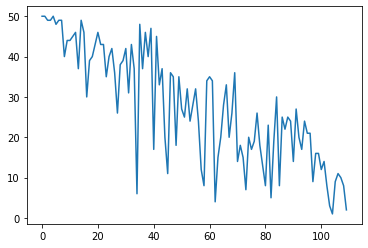

In [1611]:
for i in range(0, 1):
    if i == 0:
        model.fit(X, t, sample_weight=sigma, verbose_eval=True)
    else:
        model.fit(X, t, sample_weight=sigma, verbose_eval=True, init_model=model)
    prediction = model.predict(X)
    
    print(t.values, prediction)
    
    t[np.argsort(prediction)].reset_index(drop=True).plot()
    plt.show()